# Import Library

In [2]:
import pandas as pd
import numpy as np
# from google.colab import drive
# drive.mount("/content/drive/")

import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("Set2")
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Loading

In [3]:
# movies = pd.read_csv("/content/drive/MyDrive/movies-dataset/movies.csv")
# ratings = pd.read_csv("/content/drive/MyDrive/movies-dataset/ratings.csv")

In [4]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

# EDA

## Menganalisis Rincian Dataset

Melihat rincian dari dataset movies

In [39]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Insight**
- Terdapat 3 kolom pada dataset yang terdiri dari:
  - `movieId` : identitas dari film yang memiliki tipe data int64 (numerikal)
  - `title` : judul dari film yang memiliki tipe data object (kategorikal)
  - `genres` : genre dari film yang memiliki tipe data object (kategorikal)
- Semua kolom pada data memiliki jumlah baris yang sama yaitu 9742 baris data.

Melihat rincian dari dataset movies

In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


**Insight**
- Terdapat 4 kolom pada dataset yang terdiri dari:
  - `userId` : identitas dari pengguna yang memiliki tipe data int64 (numerikal)
  - `movieId` : identitas dari film yang memiliki tipe data int64 (numerikal)
  - `rating` : rating atau penilaian pengguna terhadap film yang memiliki tipe data float64 (numerikal)
  - `timestamp` : waktu pengguna memberi rating pada film yang memiliki tipe data int64 (numerikal)
- Semua kolom pada data memiliki jumlah baris yang sama yaitu 100836 baris data.

## Melihat Ringkasan Data

Melihat dataset movies

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


**Insight**
- Kolom movie id berisi data numerik increment berurutan dari angka 1
- Kolom title berisi judul dari film beserta tahun rilisnya
- Kolom genres berisi beberapa genre yang dipisahkan oleh karakter '|' dari film tersebut.
- Data pada kolom genres perlu dibersihkan untuk mengambil genre utamanya saja

Melihat dataset ratings

In [14]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**Insight**
- Data berurutan dimulai dari user id 1
- Kolom rating berisi rating pengguna yang memiliki tipe data float kemungkinan terdapat rating dengan nilai pecahan atau koma
  

## Memeriksa Missing Values dan Data Duplikat

Memeriksa dataset movies

In [44]:
null_val = movies.isna().sum()
duplicated_data = movies.duplicated().sum()
print("=============================================")
print(f"Jumlah Missing Values Pada Dataset Movies: \n{null_val}")
print(f"Jumlah Data Duplikat Pada Dataset Movies: {duplicated_data}")
print("=============================================")

Jumlah Missing Values Pada Dataset Movies: 
movieId    0
title      0
genres     0
dtype: int64
Jumlah Data Duplikat Pada Dataset Movies: 0


Memeriksa dataset ratings

In [43]:
null_val = ratings.isna().sum()
duplicated_data = ratings.duplicated().sum()
print("=============================================")
print(f"Jumlah Missing Values Pada Dataset Ratings: \n{null_val}")
print(f"Jumlah Data Duplikat Pada Dataset Ratings: {duplicated_data}")
print("=============================================")

Jumlah Missing Values Pada Dataset Ratings: 
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Jumlah Data Duplikat Pada Dataset Ratings: 0


**Insight**
- Tidak ada nilai yang hilang atau missing values pada dataset movies dan ratings
- Tidak ada data yang duplikat pada dataset movies dan ratings

## Analisis Distribusi Data

Membersihkan data genres dengan mengambil genre utamanya saja

In [8]:
movies['genres'] = movies['genres'].str.split('|').str[0]
movies['genres'].value_counts()

genres
Comedy                2779
Drama                 2226
Action                1828
Adventure              653
Crime                  537
Horror                 468
Documentary            386
Animation              298
Children               197
Thriller                84
Sci-Fi                  62
Mystery                 48
Fantasy                 42
Romance                 38
(no genres listed)      34
Western                 23
Musical                 23
Film-Noir               12
War                      4
Name: count, dtype: int64

Membuat fungsi untuk menampilkan distribusi setiap data

In [5]:
def cekDistribusi(dataframe, kolom):
    df = dataframe.copy()
    fitur = df[kolom].value_counts().sort_values(ascending=False).index
    total = len(df)

    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, x=kolom, order=fitur, palette=palette)

    # Menambahkan nilai aktual dan persentase di atas setiap bar
    for p in ax.patches:
        nilai = int(p.get_height())
        # persentase = 100 * nilai / total
        ax.annotate(f'{nilai}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=8)

    plt.title(f'Distribusi Kolom {kolom}')
    plt.xlabel(kolom)
    plt.ylabel('Jumlah')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Menampilkan distribusi data genres pada dataset movies

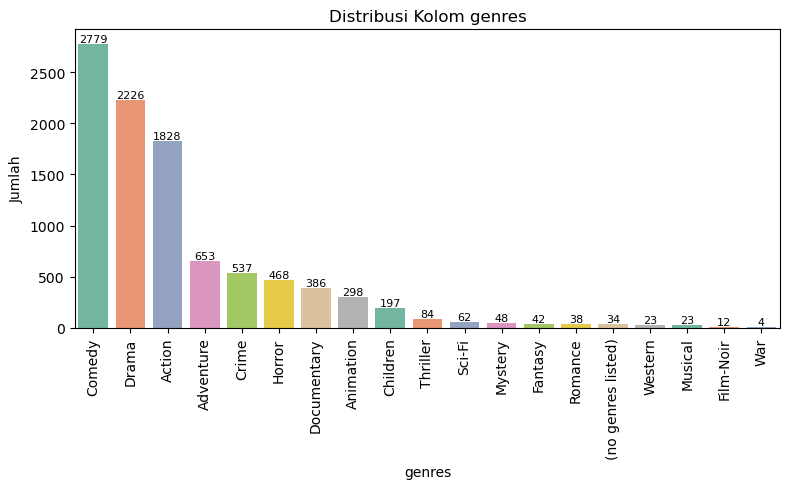

In [6]:
cekDistribusi(movies, 'genres')

Menampilkan distribusi data rating pada dataset ratings

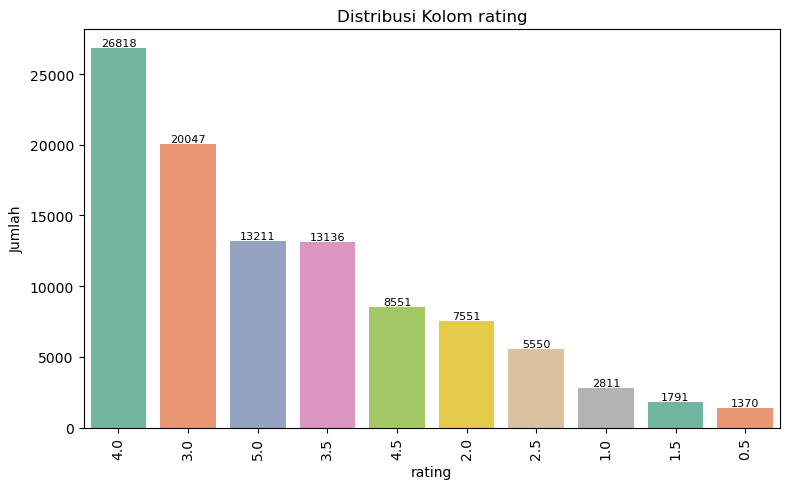

In [7]:
cekDistribusi(ratings, 'rating')

# Data Preparation

## Data Cleaning

Menangani Missing Values dan Duplicated Data pada Dataset Movies

In [9]:
clean_movies = movies.dropna().drop_duplicates()
clean_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Menangani Missing Values dan Duplicated Data pada Dataset Ratings

In [10]:
clean_ratings = ratings.dropna().drop_duplicates()
clean_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## Pemilihan Fitur

### Dataset Movies

Menghapus nilai **(no_genres_listed)** pada kolom genres

In [11]:
clean_movies = clean_movies[clean_movies['genres'] != '(no genres listed)'] 
clean_movies['genres'].unique()

array(['Adventure', 'Comedy', 'Action', 'Drama', 'Crime', 'Children',
       'Mystery', 'Animation', 'Documentary', 'Thriller', 'Horror',
       'Fantasy', 'Western', 'Film-Noir', 'Romance', 'Sci-Fi', 'Musical',
       'War'], dtype=object)

### Dataset Ratings

Menghapus fitur atau kolom `timestamp` karena fitur tersebut tidak relevan untuk melakukan pemodelan

In [12]:
clean_ratings = clean_ratings.drop(columns=['timestamp'], axis=1)
clean_ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


## Text Processing

In [13]:
clean_movies['genres'].unique()

array(['Adventure', 'Comedy', 'Action', 'Drama', 'Crime', 'Children',
       'Mystery', 'Animation', 'Documentary', 'Thriller', 'Horror',
       'Fantasy', 'Western', 'Film-Noir', 'Romance', 'Sci-Fi', 'Musical',
       'War'], dtype=object)

In [14]:
clean_movies['genres'] = clean_movies['genres'].replace({'Sci-Fi':'SciFi', 'Film-Noir':'Filmnoir'})
print(clean_movies[clean_movies['genres'] == 'SciFi'].head())
print(clean_movies[clean_movies['genres'] == 'Filmnoir'].head())

      movieId                                  title genres
668       880       Island of Dr. Moreau, The (1996)  SciFi
1320     1779                          Sphere (1998)  SciFi
1719     2311  2010: The Year We Make Contact (1984)  SciFi
1902     2526                          Meteor (1979)  SciFi
2000     2661        It Came from Outer Space (1953)  SciFi
      movieId                       title    genres
279       320               Suture (1993)  Filmnoir
695       913  Maltese Falcon, The (1941)  Filmnoir
711       930            Notorious (1946)  Filmnoir
913      1212       Third Man, The (1949)  Filmnoir
1531     2066      Out of the Past (1947)  Filmnoir


In [15]:
groupped_ratings = clean_ratings.groupby('movieId')
groupped_ratings

## Data Transformation

### TF-IDF Vectorizer

In [16]:
tfidf = TfidfVectorizer()

tfidf.fit(clean_movies['genres'])
tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'filmnoir', 'horror', 'musical',
       'mystery', 'romance', 'scifi', 'thriller', 'war', 'western'],
      dtype=object)

In [17]:
genre_tfid_cbf = tfidf.fit_transform(clean_movies['genres']) 
genre_tfid_cbf.shape

(9708, 18)

In [18]:
genre_tfid_cbf.todense()

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### Cosine Simmilarity

In [19]:
genre_cosin_cbf = cosine_similarity(genre_tfid_cbf)
genre_cosin_cbf

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [23]:
genre_cosin_df = pd.DataFrame(genre_cosin_cbf, index=clean_movies['title'], columns=clean_movies['title'])
genre_cosin_df.sample(5, axis=1, random_state=42).sample(5, axis=0, random_state=42)

title,Wrong Turn (2003),"Jewel of the Nile, The (1985)",Major Dundee (1965),Vigilante Diaries (2016),We Own the Night (2007)
title,,,,,
Wrong Turn (2003),1.0,0.0,0.0,0.0,0.0
"Jewel of the Nile, The (1985)",0.0,1.0,0.0,1.0,0.0
Major Dundee (1965),0.0,0.0,1.0,0.0,0.0
Vigilante Diaries (2016),0.0,1.0,0.0,1.0,0.0
We Own the Night (2007),0.0,0.0,0.0,0.0,1.0


### Data Encoding

In [24]:
clean_ratings_encode = clean_ratings.copy()

In [25]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = clean_ratings_encode['userId'].unique().tolist()
print('list userID: ', user_ids)

# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [26]:
# Mengubah placeID menjadi list tanpa nilai yang sama
movies_ids = clean_ratings_encode['movieId'].unique().tolist()

# Melakukan proses encoding placeID
movies_to_movies_encoded = {x: i for i, x in enumerate(movies_ids)}

# Melakukan proses encoding angka ke placeID
movies_encoded_to_movies = {i: x for i, x in enumerate(movies_ids)}

In [27]:
# Mapping userID ke dataframe user
clean_ratings_encode['user'] = clean_ratings_encode['userId'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
clean_ratings_encode['movies'] = clean_ratings_encode['movieId'].map(movies_to_movies_encoded)
clean_ratings_encode.head()

,userId,movieId,rating,user,movies
0,1,1,4.0,0,0
1,1,3,4.0,0,1
2,1,6,4.0,0,2
3,1,47,5.0,0,3
4,1,50,5.0,0,4


In [28]:
# Mendapatkan jumlah user
jumlah_users = len(user_to_user_encoded)
print(jumlah_users)

# Mendapatkan jumlah resto
jumlah_movies = len(movies_encoded_to_movies)
print(jumlah_movies)

# Mengubah rating menjadi nilai float
clean_ratings_encode['rating'] = clean_ratings_encode['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(clean_ratings_encode['rating'])

# Nilai maksimal rating
max_rating = max(clean_ratings_encode['rating'])

print('Number of User: {}, Number of movies: {}, Min Rating: {}, Max Rating: {}'.format(
    jumlah_users, jumlah_movies, min_rating, max_rating
))

610
9724
Number of User: 610, Number of movies: 9724, Min Rating: 0.5, Max Rating: 5.0


## Data Splitting

Mengacak data ratings terlebih dahulu agar distribusinya menjadi random

In [29]:
clean_ratings_random = clean_ratings_encode.sample(frac=0.1, random_state=42)
clean_ratings_random

,userId,movieId,rating,user,movies
67037,432,77866,4.5,431,4730
42175,288,474,3.0,287,474
93850,599,4351,3.0,598,2631
6187,42,2987,4.0,41,194
12229,75,1610,4.0,74,727
...,...,...,...,...,...
52065,339,1580,2.0,338,101
92269,597,1090,5.0,596,63
18346,116,30749,4.5,115,890
17425,111,5025,3.0,110,4497


Membagi data menjadi variabel X dan y dan menerapkan normalisasi untuk data rating

In [30]:
X = clean_ratings_random[['user', 'movies']].values

y = clean_ratings_random['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [31]:
train_indices = int(0.8 * clean_ratings_random.shape[0])
x_train, x_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(X, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 115  890]
 [ 110 4497]
 [ 478  312]] [0.88888889 0.55555556 0.55555556 ... 0.88888889 0.55555556 0.33333333]


# Modelling

## Content-Based Filtering Model

In [32]:
def movies_recommendations(nama_movies, similarity_data=genre_cosin_df, items=clean_movies[['title', 'genres']], k=5):
    """
    Rekomendasi movies berdasarkan kemiripan dataframe

    Parameter:
    ---
    nama_movies : tipe data string (str)
                Nama movies (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan movies sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,nama_movies].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_movies agar nama movies yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(nama_movies, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [33]:
clean_movies[clean_movies['title'] == 'Toy Story (1995)']

,movieId,title,genres
0,1,Toy Story (1995),Adventure


In [34]:
movies_recommendations('Toy Story (1995)')

,title,genres
0,Touching the Void (2003),Adventure
1,Over the Hedge (2006),Adventure
2,RV (2006),Adventure
3,"Shaggy Dog, The (2006)",Adventure
4,"Pink Panther, The (2006)",Adventure


## Collaborative Filtering Model

In [35]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movies_embedding = layers.Embedding( # layer embeddings movies
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movies_bias = layers.Embedding(num_movies, 1) # layer embedding movies bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movies_vector = self.movies_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movies_bias = self.movies_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movies = tf.tensordot(user_vector, movies_vector, 2)

    x = dot_user_movies + user_bias + movies_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [36]:
model = RecommenderNet(jumlah_users, jumlah_movies, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [37]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 30,
    validation_data = (x_val, y_val)
)

Epoch 1/30
1009/1009 [==============================] - 13s 11ms/step - loss: 0.6816 - root_mean_squared_error: 0.2749 - val_loss: 0.6656 - val_root_mean_squared_error: 0.2632
Epoch 2/30
1009/1009 [==============================] - 9s 9ms/step - loss: 0.6328 - root_mean_squared_error: 0.2276 - val_loss: 0.6479 - val_root_mean_squared_error: 0.2460
Epoch 3/30
1009/1009 [==============================] - 9s 9ms/step - loss: 0.6194 - root_mean_squared_error: 0.2141 - val_loss: 0.6451 - val_root_mean_squared_error: 0.2433
Epoch 4/30
1009/1009 [==============================] - 10s 10ms/step - loss: 0.6123 - root_mean_squared_error: 0.2065 - val_loss: 0.6427 - val_root_mean_squared_error: 0.2410
Epoch 5/30
1009/1009 [==============================] - 14s 14ms/step - loss: 0.6072 - root_mean_squared_error: 0.2011 - val_loss: 0.6389 - val_root_mean_squared_error: 0.2372
Epoch 6/30
1009/1009 [==============================] - 16s 16ms/step - loss: 0.6026 - root_mean_squared_error: 0.1960 - val

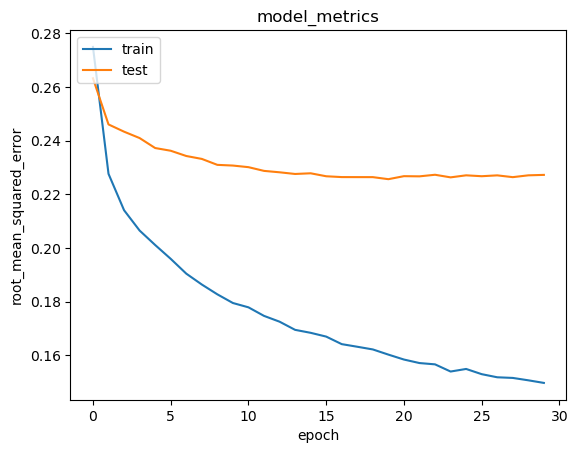

In [38]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1009/1009 [==============================] - 11s 9ms/step - loss: 0.6815 - root_mean_squared_error: 0.2748 - val_loss: 0.6665 - val_root_mean_squared_error: 0.2641
Epoch 2/100
1009/1009 [==============================] - 9s 9ms/step - loss: 0.6323 - root_mean_squared_error: 0.2271 - val_loss: 0.6495 - val_root_mean_squared_error: 0.2477
Epoch 3/100
1009/1009 [==============================] - 9s 9ms/step - loss: 0.6205 - root_mean_squared_error: 0.2153 - val_loss: 0.6477 - val_root_mean_squared_error: 0.2459
Epoch 4/100
1009/1009 [==============================] - 16s 15ms/step - loss: 0.6125 - root_mean_squared_error: 0.2067 - val_loss: 0.6421 - val_root_mean_squared_error: 0.2403
Epoch 5/100
1009/1009 [==============================] - 21s 21ms/step - loss: 0.6066 - root_mean_squared_error: 0.2003 - val_loss: 0.6400 - val_root_mean_squared_error: 0.2384
Epoch 6/100
1009/1009 [==============================] - 21s 20ms/step - loss: 0.6024 - root_mean_squared_error: 0.1957 

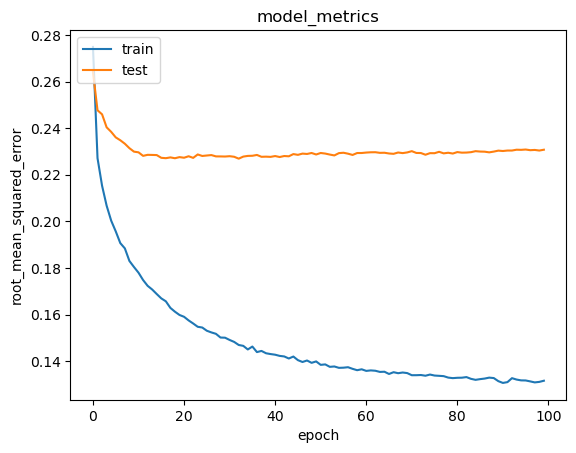

In [39]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing

In [52]:
df = pd.read_csv("ratings.csv")
movies_df = pd.read_csv("movies.csv")
movies_df['genres'] = movies_df['genres'].str.split('|').str[0]
user_id = df.userId.sample(1).iloc[0]
movies_viewed_by_user = df[df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movies_not_viewed = movies_df[~movies_df['movieId'].isin(movies_viewed_by_user.movieId.values)]['movieId']
movies_not_viewed = list(
    set(movies_not_viewed)
    .intersection(set(movies_to_movies_encoded.keys()))
)

movies_not_viewed = [[movies_to_movies_encoded.get(x)] for x in movies_not_viewed]
user_encoder = user_to_user_encoded.get(user_id)
movies_array = np.hstack(
    ([[user_encoder]] * len(movies_not_viewed), movies_not_viewed)
)

In [53]:
ratings = model.predict(movies_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movies_ids = [
    movies_to_movies_encoded.get(movies_not_viewed[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('movies with high ratings from user')
print('----' * 8)

top_movies_user = (
    movies_viewed_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movies_df_rows = movies_df[movies_df['movieId'].isin(top_movies_user)]
for row in movies_df_rows.itertuples():
    print(row.title, ':', row.genres)

print('----' * 8)
print('Top 10 movies recommendation')
print('----' * 8)

recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movies_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ':', row.genres)

290/290 [==============================] - 0s 1ms/step
Showing recommendations for users: 509
movies with high ratings from user
--------------------------------
Great Dictator, The (1940) : Comedy
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adventure
Lord of the Rings: The Two Towers, The (2002) : Adventure
Lord of the Rings: The Return of the King, The (2003) : Action
Pitch Perfect 2 (2015) : Comedy
--------------------------------
Top 10 movies recommendation
--------------------------------
Ready to Wear (Pret-A-Porter) (1994) : Comedy
Killing Zoe (1994) : Crime
War Room, The (1993) : Documentary
Germinal (1993) : Drama
Gridlock'd (1997) : Crime
Christmas Vacation (National Lampoon's Christmas Vacation) (1989) : Comedy
Love Me Tender (1956) : Musical
